# Multiclass Classification on the Iris Dataset

---

This notebook demonstrates the application of the end-to-end PyTorch workflow from **Chapter 12** to a real-world, classic machine learning problem: **Multiclass Classification** using the **Iris Flower Dataset**.

This exercise moves beyond simple linear regression by introducing a multilayer network and a final activation function necessary for classification.

### Key Topics and Implementations:

* **Data Preparation (Scikit-learn Integration):**
    * The **Iris dataset** is loaded using `sklearn.datasets.load_iris()`.
    * The data is split into training and testing sets using `sklearn.model_selection.train_test_split`.
    * Features are scaled (normalized) and converted to **PyTorch Tensors**.
* **Data Pipeline Setup:**
    * The normalized Tensors are combined into a **`TensorDataset`**.
    * A **`DataLoader`** is initialized to handle batching and iteration during training.
* **Multilayer Model Definition (`Model` class):**
    * A custom network class is defined, inheriting from `nn.Module`, featuring **multiple hidden layers** to introduce non-linearity.
    * The final output layer has 3 units, corresponding to the three Iris flower classes (Setosa, Versicolor, Virginica).
* **Training and Evaluation:**
    * **Loss Function:** `nn.CrossEntropyLoss` is used, which is appropriate for multiclass problems and implicitly includes the Softmax activation.
    * **Optimizer:** An optimizer (e.g., `optim.Adam` or `optim.SGD`) is used to minimize the loss over multiple epochs.
    * The training loop iterates through the `DataLoader`, performing the standard forward pass, loss calculation, backward pass (`loss.backward()`), and parameter update (`optimizer.step()`).
* **Model Persistence (Saving and Loading):**
    * The notebook includes code to **save the trained model's parameters** using `torch.save(model.state_dict(), path)`.
    * The trained parameters are saved to a file (e.g., **`iris_classifier_state.pt`**).
    * A new model instance is then created and the saved state dictionary is loaded using **`new_model.load_state_dict(torch.load(path))`**, verifying that the trained model can be successfully persisted and reused.

This notebook successfully demonstrates the complete PyTorch stack for a small-scale classification task, including best practices for data handling and model deployment.

In [37]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [46]:
iris = load_iris()
X = iris['data']
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size= 1. / 3, random_state= 28
)

In [49]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)
y_train = y_train.to(dtype= torch.int64)
train_ds = TensorDataset(X_train_norm, y_train)

In [50]:
torch.manual_seed(28)
train_dl = DataLoader(train_ds, batch_size= 2, shuffle= True)

In [51]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim= 1)(x)
        return x

In [52]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
iris_model = Model(input_size, hidden_size, output_size)

In [53]:
learning_rate = 0.01
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(iris_model.parameters() ,lr= learning_rate)

In [54]:
epochs = 100
loss_hist = [0] * epochs
acc_hist = [0] * epochs
log_epoch = 10
for epoch in range(epochs):
    for (x_batch, y_batch) in train_dl:
        pred = iris_model(x_batch)
        loss = loss_func(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim= 1) == y_batch).float()
        acc_hist[epoch] += is_correct.mean()
    loss_hist[epoch] /= len(train_dl.dataset)
    acc_hist[epoch] /= len(train_dl.dataset)

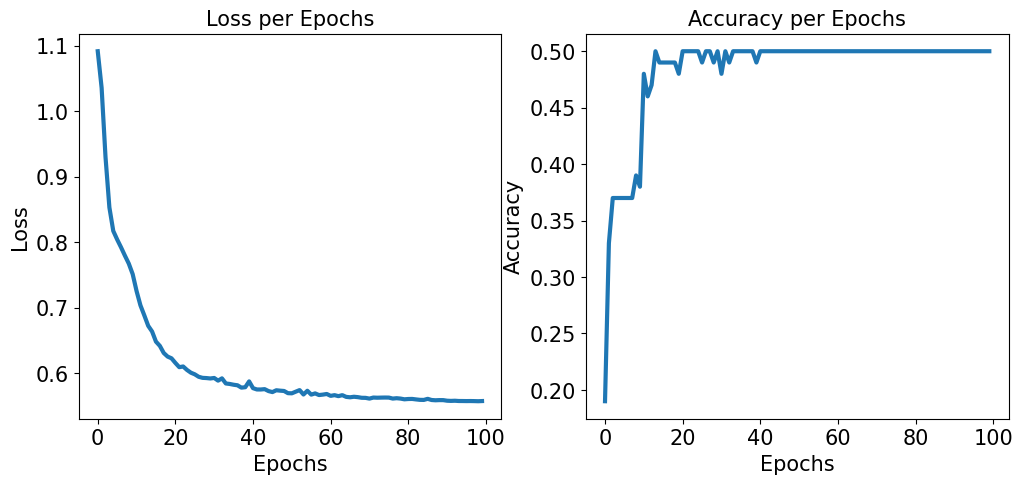

In [65]:
fig, axs = plt.subplots(1, 2, figsize= (12, 5))
axs[0].plot(loss_hist, lw= 3)
axs[0].set_xlabel('Epochs', fontsize= 15)
axs[0].set_ylabel('Loss', fontsize= 15)
axs[0].set_title('Loss per Epochs', size= 15)
axs[0].tick_params(axis= 'both', labelsize= 15)

axs[1].plot(acc_hist, lw= 3)
axs[1].set_xlabel('Epochs', size= 15)
axs[1].set_ylabel('Accuracy', size= 15)
axs[1].set_title('Accuracy per Epochs', fontsize= 15)
axs[1].tick_params(axis= 'both', labelsize= 15)

In [66]:
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)
y_test = y_test.to(dtype= torch.int64)
preds = iris_model(X_test_norm)
correct = (torch.argmax(preds, dim= 1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc. : {accuracy:.4f}')

Test Acc. : 0.9500


In [67]:
path = 'iris_classifier.pt'
torch.save(iris_model, path)

In [69]:
load_iris_m = torch.load(path, weights_only= False)

In [70]:
load_iris_m.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [71]:
preds = load_iris_m(X_test_norm)
correct = (torch.argmax(preds, dim= 1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc. : {accuracy:.4f}')

Test Acc. : 0.9500


In [73]:
path2 = 'iris_classifier_state.pt'
torch.save(iris_model.state_dict(), path)

In [74]:
new_model = Model(input_size, hidden_size, output_size)
new_model.load_state_dict(torch.load(path2))

<All keys matched successfully>